In [99]:
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import distrax
import pandas as pd
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
import seaborn as sns
import ot
from dataclasses import dataclass
from ensembles import ProcessModel, ModelCollection, LogLikelihoodWeight, Barycentre
from ensembles.plotters import get_style_cycler, cmap, _unique_legend
from ensembles.weights import InverseSquareWeight, UniformWeight
from ensembles.ensemble_scheme import WeightedModelMean
from ensembles.ensemble_scheme import MultiModelMean
import xarray as xr
%matplotlib inline

[autoreload of ensembles.data failed: Traceback (most recent call last):
  File "/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File 

In [100]:
# Enable Floa64 - this is crucial for more stable matrix inversions.
config.update("jax_enable_x64", True)

key = jr.PRNGKey(123)

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading a plotting models and observations

Read all the model files in. Each model file is a csv where each column is a realisation from that model.

In [102]:
model_hist_files = glob('data/gmst/historical/*nc')
model_hist_names = [mf.split("/")[-1][:-3] for mf in model_hist_files]

model_ssp370_files = glob('data/gmst/ssp370/*.nc')
model_ssp370_names = [mf.split("/")[-1][:-3] for mf in model_ssp370_files]

Find the overlap in models, they need to exist both in the historical and the ssp

We read in a set of observations and put this into a $\texttt{ProcessModel}$ object that stores the data of all the observational realisations

In [103]:
obs_da = xr.load_dataarray("data/obs/GMST_OBS.nc")
observations = ProcessModel(obs_da, model_name='Observations')

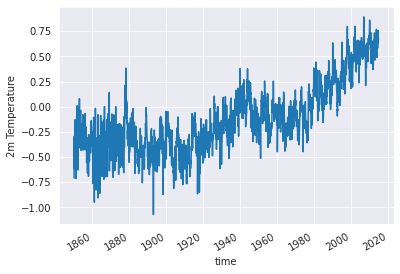

In [112]:
observations.mean_across_realisations

Here, we load in all the model data (again into seperate $\texttt{ProcessModel}$ data classes). We then find the anomally of each model such that we can compare the model realisations directly with the observations (these come as an anomally).

In [106]:
anom_models = []
models = []

for mf, mn in zip(model_hist_files, model_hist_names):
    da = xr.load_dataarray(mf)

    model_data = ProcessModel(da, mn)
    models.append(model_data)

    # Find the anomally of that data
    anomaly_data = model_data.calculate_anomaly()
    anom_models.append(anomaly_data)

We store the anomalised and non-anomalised ensemble model output in a $\texttt{ModelCollection}$ data class which contains all the ensemble data as well as providing plotting functionality

In [107]:
anom_models = ModelCollection(anom_models)
models = ModelCollection(models)

We can look at all the models (anomalised)

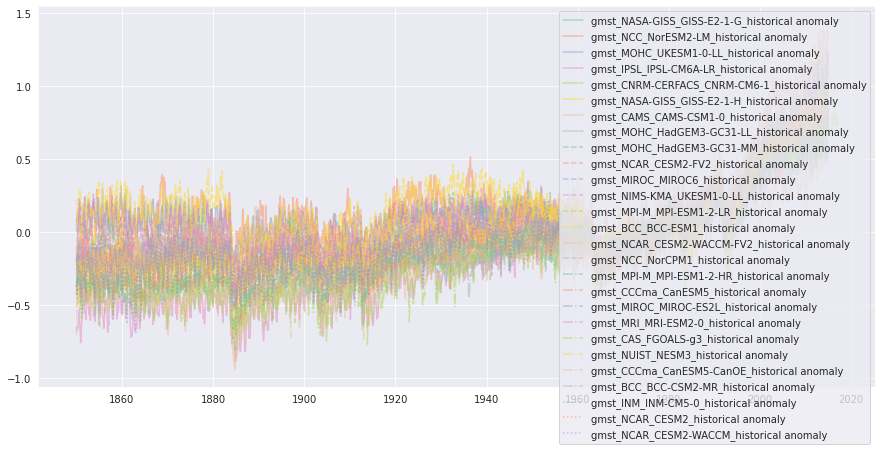

In [108]:
anom_models.plot_all()

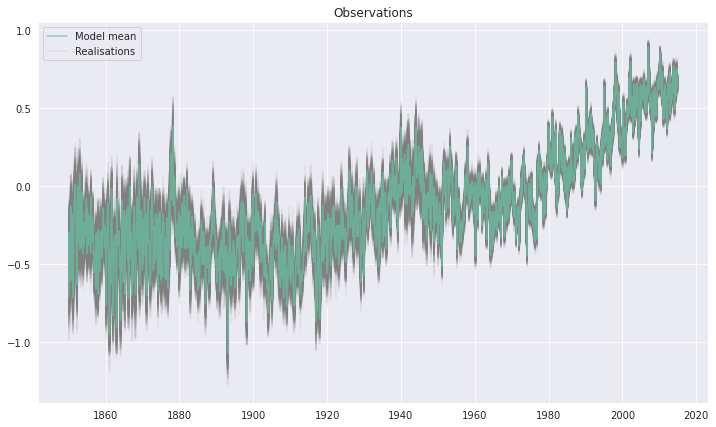

In [109]:
observations.plot()

or plot the models seperately with their individual realisations and means

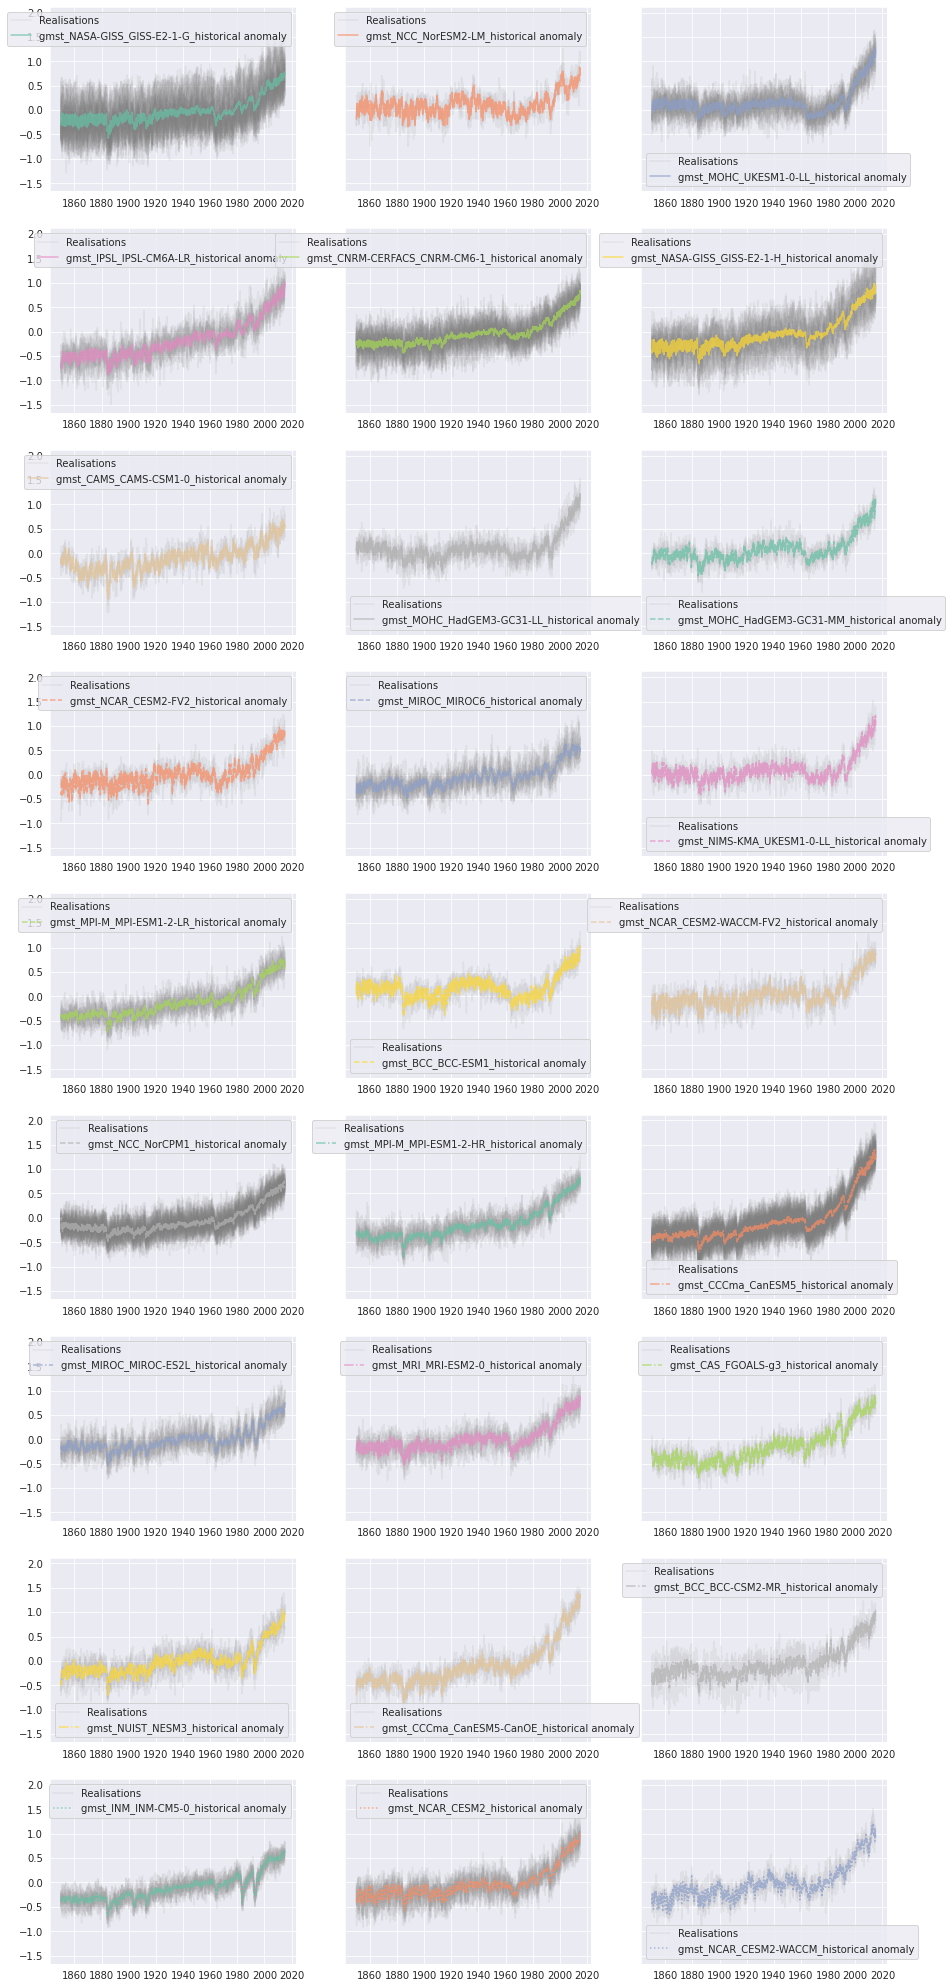

In [39]:
anom_models.plot_grid()

## Looking at weights

Now we can weight the models on how well each model distribution matches the realisations. This we do here by calculating the log-likelihood between the model pdf and the observational realisations.

In [110]:
mse_weights = InverseSquareWeight()(anom_models, observations)
uniform_weights = UniformWeight()(anom_models, observations)
# ll_weights, lls = LogLikelihoodWeight()(anom_models, observations, return_lls=True)

In [116]:
uniform_weights.mean('time')

<xarray.DataArray '2m Temperature' (model: 27)>
array([0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704])
Dimensions without coordinates: model

Are the log-likelihoods sensible? We look at prescaled values becuase this means the LLs are independent of all other models

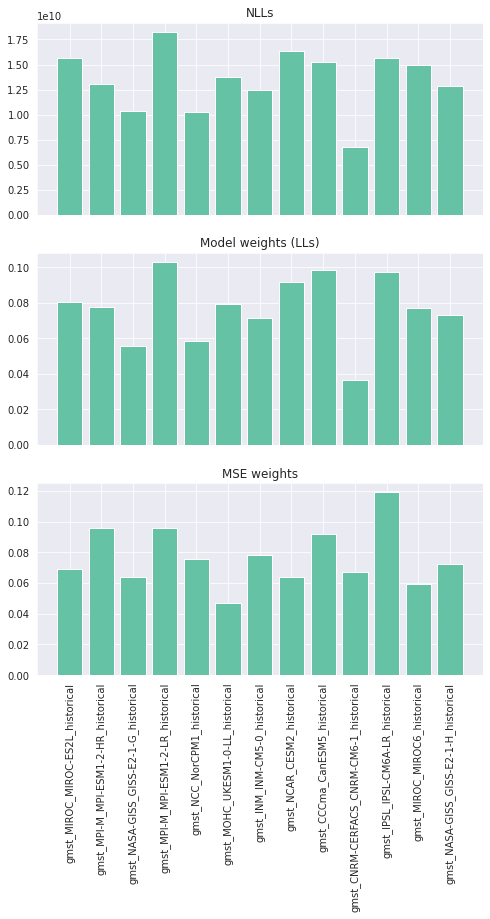

In [13]:
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(8, 12))
axes[0].bar(model_names, -jnp.mean(lls, axis=0), color=cmap()[0])
axes[0].set_title('NLLs')

axes[1].bar(model_names, jnp.mean(ll_weights, axis=0), color=cmap()[0])
axes[1].set_title('Model weights (LLs)')

axes[2].bar(model_names, jnp.mean(mse_weights, axis=0), color=cmap()[0])
axes[2].set_title('MSE weights')
axes[2].tick_params(axis='x', labelrotation=90)
plt.show()

Well this is interesting. The weights you get from the loglikelihood (middle panel) are very different and fairly uncorrelated to those weights you would derive using a typical inverse square weighting between realisation mean and observational mean.

What about weights in time? Firstly seasonal, then for all time.

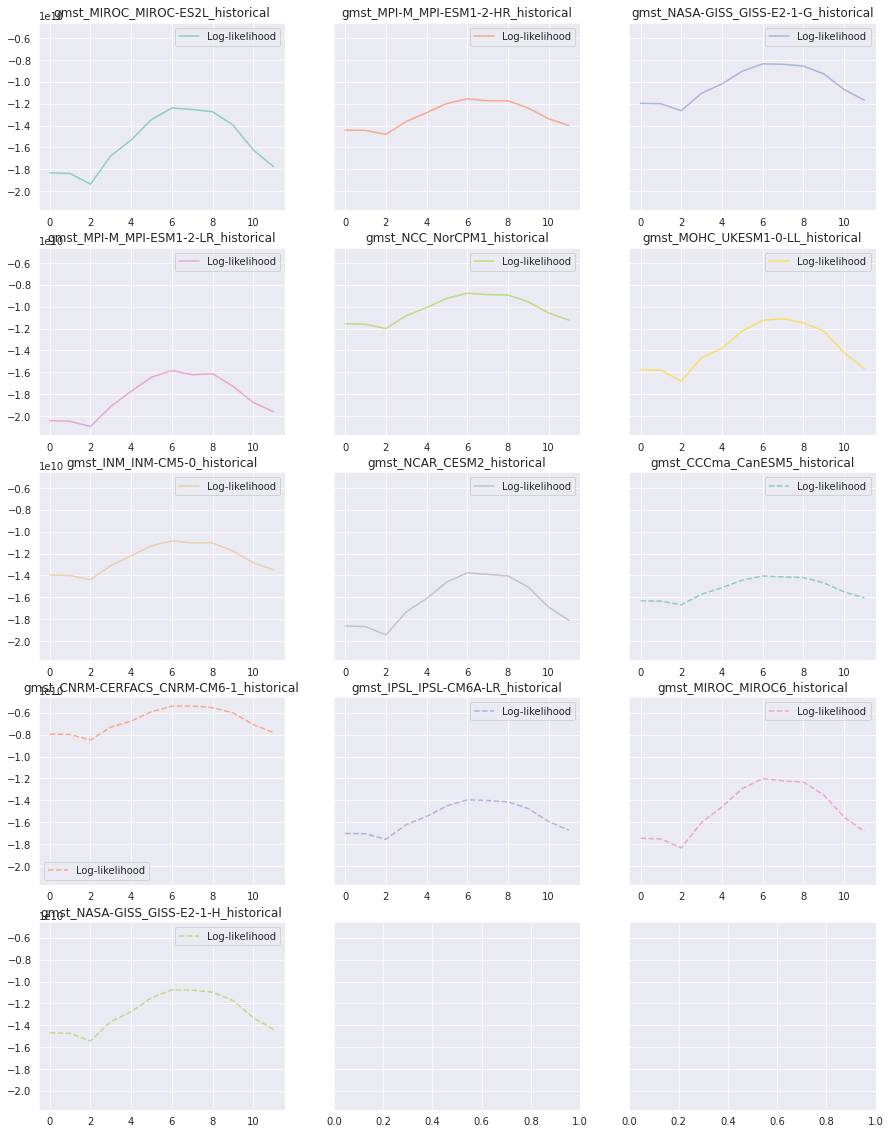

In [14]:
style_cycler = get_style_cycler()
fig, axes = plt.subplots(
    figsize=(15, 4 * np.ceil(models.number_of_models/3)),
    nrows=round(np.ceil(models.number_of_models/3)),
    ncols=3,
    sharey=True)
for weight, ax, kwargs, model_name in zip(lls.T, axes.ravel(), style_cycler, models.model_names):
    x = np.arange(12)
    seas_weight = np.mean(weight.reshape(-1, 12), axis=0)
    ax.set_title(model_name)
    ax.plot(x, seas_weight, alpha=0.7, label='Log-likelihood', **kwargs)
    ax.legend(loc='best')
fig.show()

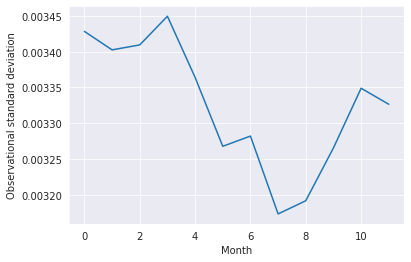

In [15]:
plt.plot(np.arange(12), np.mean(observations.temporal_covariance.diagonal().reshape(-1, 12), axis=0))
plt.xlabel('Month')
plt.ylabel('Observational standard deviation')
plt.show()

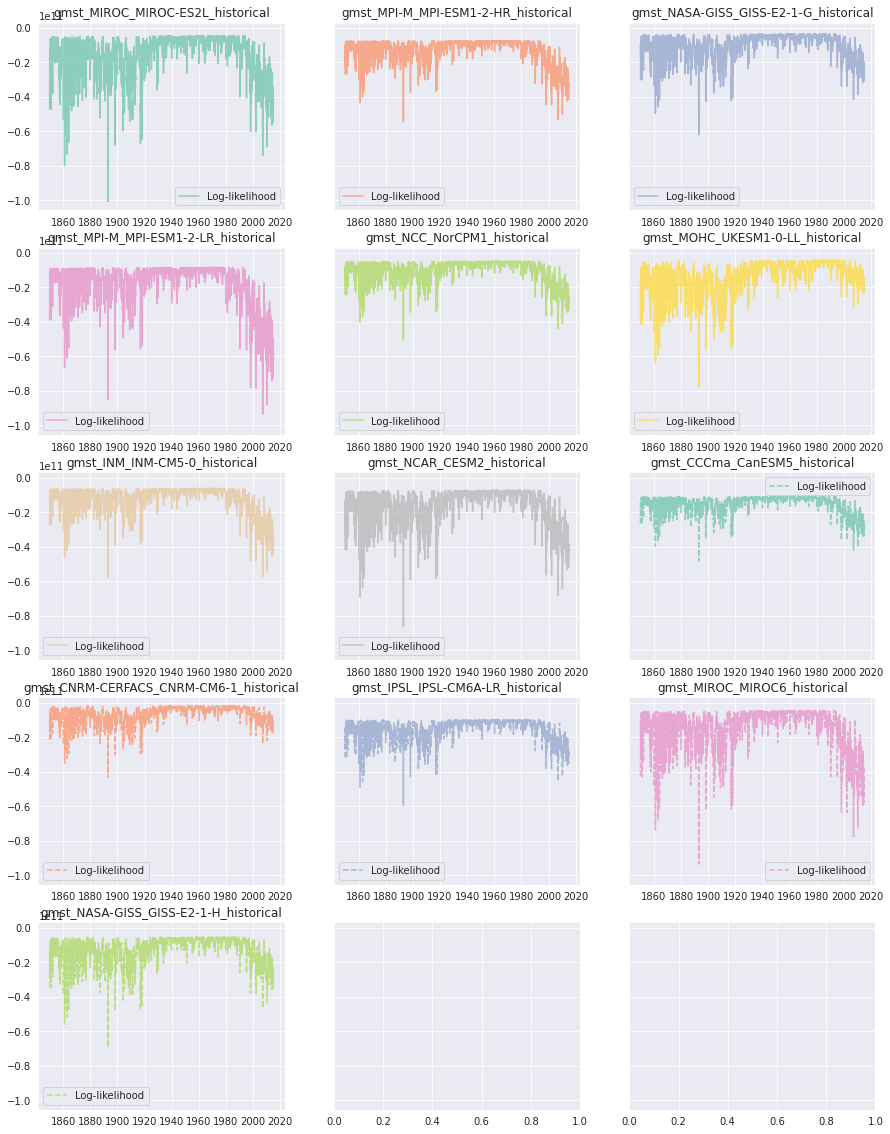

In [16]:
style_cycler = get_style_cycler()
fig, axes = plt.subplots(
    figsize=(15, 4 * np.ceil(models.number_of_models/3)),
    nrows=round(np.ceil(models.number_of_models/3)),
    ncols=3,
    sharey=True)
for weight, ax, kwargs, model_name in zip(lls.T, axes.ravel(), style_cycler, models.model_names):
    x = observations.time
    ax.set_title(model_name)
    ax.plot(x, weight, alpha=0.7, label='Log-likelihood', **kwargs)
    ax.legend(loc='best')
fig.show()

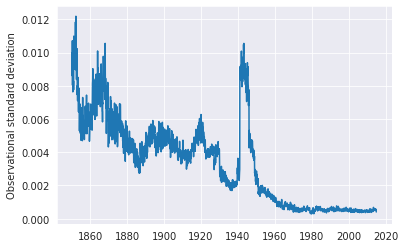

In [17]:
plt.plot(observations.time, observations.temporal_covariance.diagonal())
plt.ylabel('Observational standard deviation')
plt.show()

The above temoral loglikelihoods are interesting as they all get lower towards 2020, which means the models are becoming less good fits to the observations. I guess that this is actually an artifact of the data, because the observations should become much more certain towards the end of the 20th century, whilst the model distributions are very narrow as they are GMST. This can be seen in the plot below where the standard deviation of the observations becomes much lower in the latter half of the 20th century.  

Seasonally, all models have a higher log-likelihood in summer, so they are a better fit to the observations. There is very little dependence on observational standard deviation from a seasonal influence unlike above.

## Barycentres

From these model weights we can compute a weighted barycentre which will be our estimate of the true posterior. We compute the barycentre using the non-anomalised models to show us the absolute temperature, rather than the temperature realitive to a climatology.

In [18]:
mmm_dist = MultiModelMean()(models)
wm_dist = WeightedModelMean()(models, weights=jnp.mean(mse_weights, axis=0))
weighted_bary = Barycentre()(models, weights=np.asarray(ll_weights))
unweighted_bary = Barycentre()(models, weights=np.ones_like(np.asarray(ll_weights)) * 1/models.number_of_models)

  2%|▏         | 41/1980 [00:02<01:54, 16.97it/s]


KeyboardInterrupt: 

In [ ]:
anom_mmm_dist = MultiModelMean()(anom_models)
anom_wm_dist = WeightedModelMean()(anom_models, weights=jnp.mean(mse_weights, axis=0))
anom_weighted_bary = Barycentre()(anom_models, weights=np.asarray(ll_weights))
anom_unweighted_bary = Barycentre()(anom_models, weights=np.ones_like(np.asarray(ll_weights)) * 1/models.number_of_models)

100%|██████████| 1980/1980 [01:52<00:00, 17.64it/s]


What do these distributions look like?

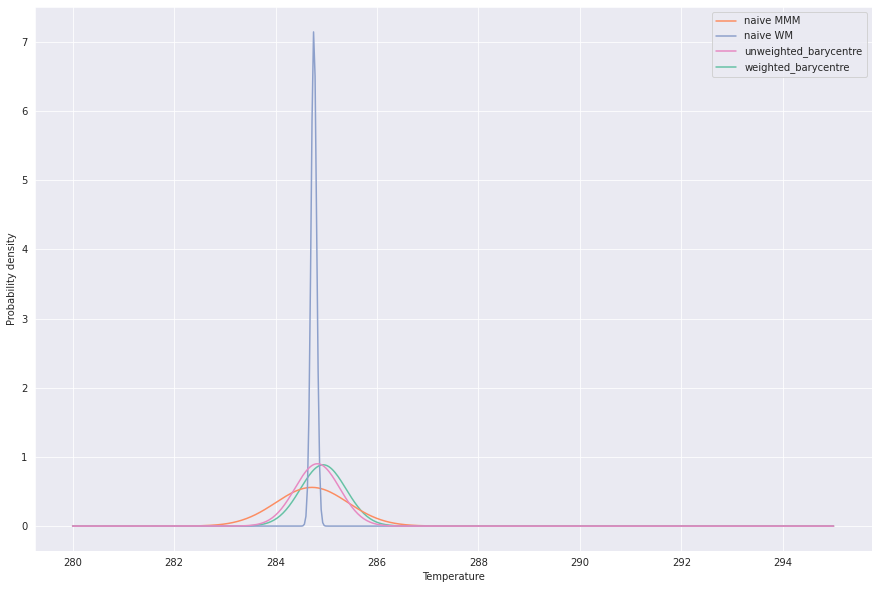

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
time_idx = 0
eval_x = np.linspace(280, 295, 500)

# Plot models
for i, model in enumerate(models):
    model_dist = model.as_multivariate_gaussian
    model_mean = model_dist.mean()[time_idx]
    model_std = jnp.sqrt(model_dist.variance()[time_idx])
    model_pdf = distrax.Normal(model_mean, model_std).prob(eval_x)
    ax.plot(eval_x, model_pdf, color='gray', label='model', alpha=float(ll_weights[time_idx, i]))

ax.set_prop_cycle(get_style_cycler())

# Plot weighted barycentre
ax.plot(eval_x, weighted_bary[time_idx].prob(eval_x), label='weighted_barycentre')

# Plot MMM
ax.plot(eval_x, mmm_dist[time_idx].prob(eval_x), label='naive MMM')

# Plot WM
ax.plot(eval_x, wm_dist[time_idx].prob(eval_x), label='naive WM')

# Plot unweighted Barycentre
ax.plot(eval_x, unweighted_bary[time_idx].prob(eval_x), label='unweighted_barycentre')

ax.set_xlabel('Temperature')
ax.set_ylabel('Probability density')

plt.legend()
ax = _unique_legend(ax)

plt.show()


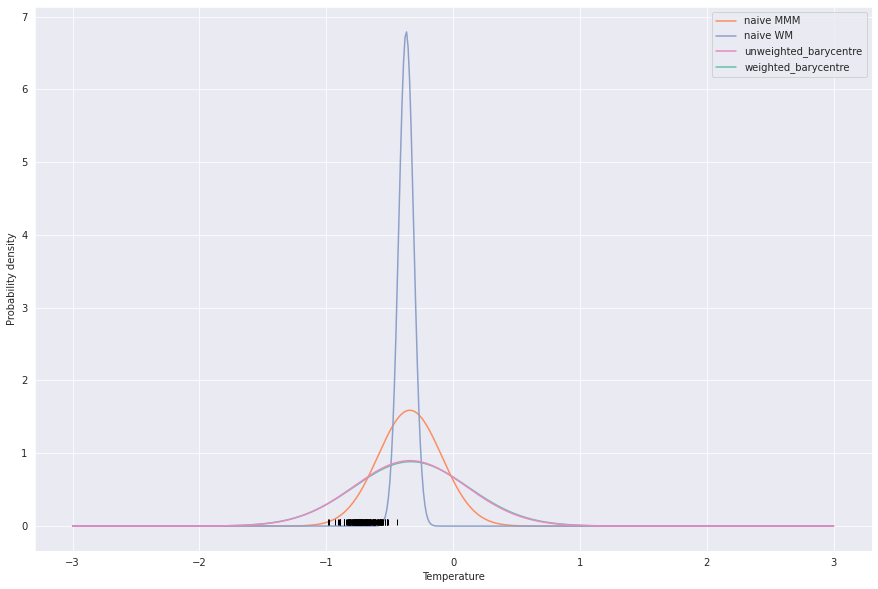

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
time_idx = 0
eval_x = np.linspace(-3, 3, 500)

# Plot models
for model in anom_models:
    model_dist = model.as_multivariate_gaussian
    model_mean = model_dist.mean()[time_idx]
    model_std = jnp.sqrt(model_dist.variance()[time_idx])
    model_pdf = distrax.Normal(model_mean, model_std).prob(eval_x)
    ax.plot(eval_x, model_pdf, color='gray', label='model', alpha=float(ll_weights[time_idx, i]))

ax.set_prop_cycle(get_style_cycler())

# Plot weighted barycentre
ax.plot(eval_x, anom_weighted_bary[time_idx].prob(eval_x), label='weighted_barycentre')

# Plot MMM
ax.plot(eval_x, anom_mmm_dist[time_idx].prob(eval_x), label='naive MMM')

# Plot WM
ax.plot(eval_x, anom_wm_dist[time_idx].prob(eval_x), label='naive WM')

# Plot unweighted Barycentre
ax.plot(eval_x, anom_unweighted_bary[time_idx].prob(eval_x), label='unweighted_barycentre')

# Plot observations
ax.plot(observations.model_data.values[time_idx, :], [0.05] * observations.n_realisations, 'k|')

ax.set_xlabel('Temperature')
ax.set_ylabel('Probability density')

plt.legend()
ax = _unique_legend(ax)

plt.show()


## Making projections

How do we best push weights forward in time?
- Assume flat weight
- Assume seasonal weights
- Model weights
- Exponentially decaying weights

Load in forecast realisations

In [ ]:
model_files = glob('data/gmst/*csv')

This above plot is confusing.

- Why are the barycentres so similar?  
- Why is the barycentre wider than any of the distributions?  
- Why is the barycentre in the anomally space so broad?

In [98]:
models[0].model_data.ndim

2

In [54]:
model_data.mean_across_realisations ** 2

<xarray.DataArray '2m Temperature' (time: 1980)>
array([81301.07259978, 81344.09670379, 81629.38001306, ...,
       83117.96188242, 82631.8455333 , 82241.48772531])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-14 ... 2014-12-15

In [86]:
m1 = models[0].mean_across_realisations.assign_coords(model=models[0].model_name)
m2 = models[1].mean_across_realisations.assign_coords(model=models[1].model_name)


In [93]:
xr.concat([m1, m2], dim='model').mean('model').shape

(1980,)

In [94]:
(1,) + (2, 2)

(1, 2, 2)

In [76]:
xr.Dataset([1])

TypeError: unhashable type: 'DataArray'

In [57]:
ds = xr.Dataset(
    {var: (("x", "y", "z"), np.random.rand(5, 3, 2)) for var in "abcde"})

In [58]:
ds

<xarray.Dataset>
Dimensions:  (x: 5, y: 3, z: 2)
Dimensions without coordinates: x, y, z
Data variables:
    a        (x, y, z) float64 0.7452 0.5948 0.7841 ... 0.5747 0.59 0.7242
    b        (x, y, z) float64 0.6971 0.559 0.7481 ... 0.8325 0.5948 0.04143
    c        (x, y, z) float64 0.2726 0.2311 0.2657 ... 0.2705 0.9511 0.2615
    d        (x, y, z) float64 0.1253 0.8213 0.5092 ... 0.4135 0.06754 0.446
    e        (x, y, z) float64 0.7762 0.06991 0.9133 ... 0.2847 0.6899 0.9236